In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib_venn import venn2

# Data

I performed an open ionbot and msfragger search (oxididation of M variable, max 2 missed cleavages).

See SOP document for more details on how MSFragger was ran.

In [18]:
#set this your local folder as the data was pushed to the repo as well
folder = "/home/compomics/tools/ionbot_paper"
datasets = ["PXD001468","PXD000561","PXD000815","PXD001250","TMTCPTAC"]
#datasets = ["PXD000815"]

 # Results
 
Load ionbot PSM results (first-matches + coeluting matches + features) + protein results.

In [19]:
def contains_missed_cleavage(x):
    if "K" in x[:-1]:
        return True
    if "R" in x[:-1]:
        return True
    return False

def is_in_s(x):
    return x in s

def get_scan_msfragger(x):
    return int(x.split('.')[-2])
def get_spectrum_file_msfragger(x):
    return x.split('.')[0]

def replace_L_I(x):
    return x.replace("L","I")

def is_decoy(x):
    return "decoy_" in x

PXD001468
PXD000561
PXD000815
PXD001250
TMTCPTAC


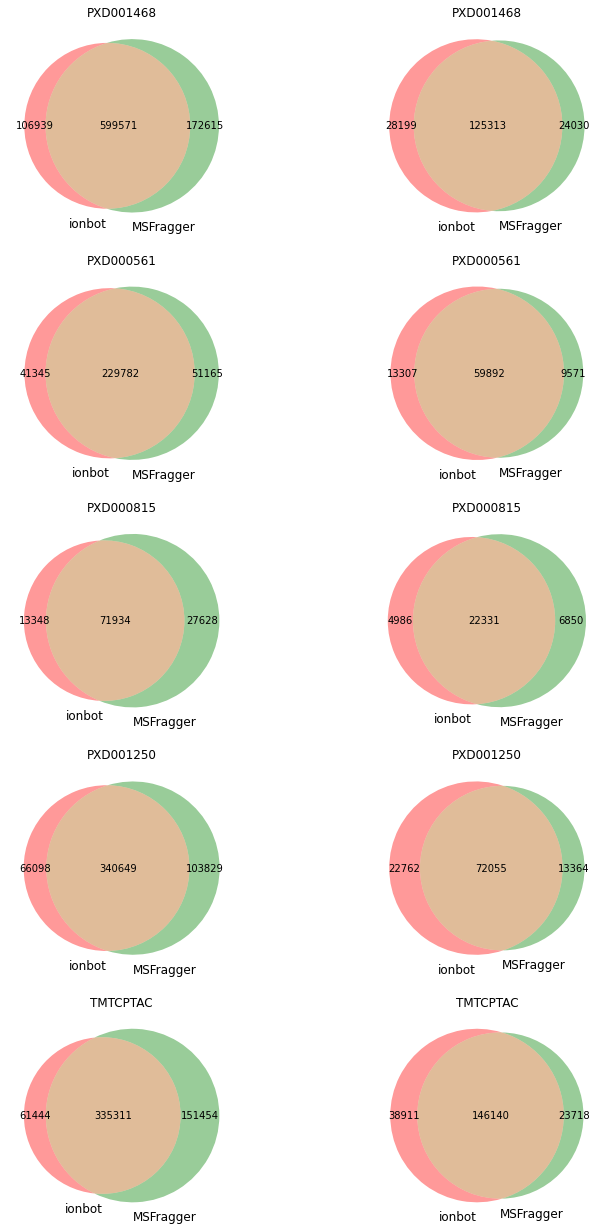

In [20]:
plt.figure(figsize=(12,22))
to_write = []
metrics = []
fi = 1
for i,dataset in enumerate(datasets):
    print(dataset)
    #Read ionbot results
    if "PXD001468" in dataset:
        def get_scan_ionbot(x):
            return int(x.split('.')[1])
        def get_spectrum_file_ionbot(x):
            return x.split('.')[0]
    else:
        def get_scan_ionbot(x):
            print(x)
            return int(x.split('=')[-1])
        def get_spectrum_file_ionbot(x):
            return x.split('.')[0]
    folder2 = folder + "/" + dataset
    ionbot = pd.read_csv("%s/ionbot.first.csv"%folder2)
    ionbot["rank"] = ["first"]*len(ionbot)
    tmp = pd.read_csv("%s/ionbot.lower.csv"%folder2)
    tmp["rank"] = ["lower"]*len(tmp)
    ionbot = pd.concat([ionbot,tmp])
    #NO IDEA WHAT HAPPENED HERE...
    ionbot = ionbot.drop_duplicates("ionbot_match_id")
    tmp = pd.read_csv("%s/ionbot.features.csv"%folder2)
    ionbot = ionbot.merge(tmp,on="ionbot_match_id",how="left")
    ionbot = ionbot[(ionbot["database"]=="T")&(ionbot["q-value"]<=0.01)]
    if "PXD001468" in dataset:
        ionbot["scan"] = ionbot["spectrum_title"].apply(get_scan_ionbot)
        ionbot["sfile"] = ionbot["spectrum_title"].apply(get_spectrum_file_ionbot)
    else:
        ionbot["sfile"] = ionbot["spectrum_file"].apply(get_spectrum_file_ionbot)
    #correction, later implemented in ionbot
    ionbot["contains_missed_cleavage"] = ionbot["matched_peptide"].apply(contains_missed_cleavage)    
    ionbot["num_passed"] = ionbot.groupby(["sfile","scan"])["scan"].transform("count")
    ionbot = ionbot[(ionbot["num_passed"]==1) |
            (ionbot["rank"]=="lower") |
            ((ionbot["num_passed"]>1) & (ionbot["rank"]=="first") & (ionbot["unexpected_modification"].isna()) & (ionbot["contains_missed_cleavage"]==False))]
    #need to re-assign best_psm
    best_psms = ionbot.sort_values("psm_score").drop_duplicates(["sfile","scan"], keep="last")
    best_psm_ids = set(best_psms["ionbot_match_id"])
    ionbot["rank"] = ionbot["ionbot_match_id"].apply(
    lambda x: "first" if x in best_psm_ids else "lower")    
    ionbot["PSM"] = ionbot["scan"].astype(str) + ionbot["sfile"] + ionbot["database_peptide"].apply(replace_L_I)
    to_write.append([dataset,"best","ionbot",len(ionbot[ionbot["rank"]=="first"]),"PSM"])
    to_write.append([dataset,"best","ionbot",len(ionbot[ionbot["rank"]=="first"]["matched_peptide"].unique()),"peptide"])
    to_write.append([dataset,"chimeric","ionbot",len(ionbot[ionbot["rank"]=="lower"]),"PSM"])
    to_write.append([dataset,"chimeric","ionbot",len(ionbot[ionbot["rank"]=="lower"]["matched_peptide"].unique()),"peptide"])

    #Read MSfragger (Prophet) result
    fragger = pd.read_csv("%s/msfragger/%s/noprotein/psm.tsv"%(folder,dataset),sep="\t")
    fragger["scan"] = fragger["Spectrum"].apply(get_scan_msfragger)
    #sfile is used to filter on spectrum file
    fragger["sfile"] = fragger["Spectrum"].apply(get_spectrum_file_msfragger)
    fragger["PSM"] = fragger["scan"].astype(str) + fragger["sfile"] + fragger["Peptide"].apply(replace_L_I)
    to_write.append([dataset,"best","MSFraggerProphet",len(fragger),"PSM"])
    to_write.append([dataset,"best","MSFraggerProphet",len(fragger["Peptide"].unique()),"peptide"])

    #adding MS2PIP correlation and retention time prediction error features:
    data_folder = "/home/compomics/extra_disk/data/%s/"%dataset
    sfiles = fragger["sfile"].unique()
    X = []
    for sf in sfiles:
        tmp = pd.read_csv("%s/%s_fragger.peprec_ionbotpeprec/ionbot.csv"%(data_folder,sf))
        tmp["sfile"] = [sf]*len(tmp)
        X.append(tmp)
    fragger_stats = pd.concat(X)
    if dataset == "PXD001468":
        def get_scan(x):
            return int(x.split(".")[1])
        fragger_stats['scan'] = fragger_stats["title"].apply(get_scan)
    fragger_stats["by-count"] = fragger_stats["count_b"] + fragger_stats["count_y"]
    fragger_stats["by-explained"] = fragger_stats["explained_b"] + fragger_stats["explained_y"]
    tmp = fragger_stats[["scan","sfile","corr","rt_diff_A","by-count","by-explained"]]
    fragger = fragger.merge(tmp,on=["scan","sfile"],how="left")

    #Read MSfragger (Percolator) results
    #read all tsv files into DataFrame
    datasets2 = ionbot["sfile"].unique()
    X = []
    for ds in datasets2:
        d = pd.read_csv("%s/msfragger/%s/%s.tsv"%(folder,dataset,ds),sep="\t")
        d["sfile"] = [ds]*len(d)
        X.append(d)
    fragger_perc = pd.concat(X)
    fragger_perc.rename(columns={'scannum':'scan'}, inplace=True)
    fragger_perc["is_decoy"] = fragger_perc["protein"].apply(is_decoy)    
    #add statistics
    X = []
    with open("%s/msfragger/%s/o"%(folder,dataset)) as f:
        f.readline()
        for row in f:
            l = row.rstrip().split('\t')
            sfile = l[0].split('.')[0]
            scan = int(l[0].split('.')[-2])
            X.append([scan,sfile,float(l[2]),float(l[3])])
    stats = pd.DataFrame(X,columns=["scan","sfile","q-value","PEP"])
    fragger_perc = fragger_perc.merge(stats,on=["scan","sfile"],how="left")
    fragger_perc["q-value"].fillna(1,inplace=True)
    fragger_perc["PEP"].fillna(1,inplace=True)
    fragger_perc = fragger_perc[(fragger_perc["is_decoy"]==False)&(fragger_perc["q-value"]<=0.01)]
    fragger_perc["PSM"] = fragger_perc["scan"].astype(str) + fragger_perc["sfile"] + fragger_perc["peptide"].apply(replace_L_I)
    to_write.append([dataset,"best","MSFraggerPercolator",len(fragger_perc),"PSM"])
    to_write.append([dataset,"best","MSFraggerPercolator",len(fragger_perc["peptide"].unique()),"peptide"])
    fragger_stats = fragger[["scan","sfile","corr","rt_diff_A","by-count","by-explained"]]
    fragger_perc = fragger_perc.merge(fragger_stats,on=["scan","sfile"],how="left")

    s1 = set(ionbot[ionbot["rank"]=="first"]["PSM"])
    s2 = set(fragger["PSM"])

    s = (len(s1.difference(s2)),
        len(s2.difference(s1)),
        len(s1.intersection(s2)))
    plt.subplot(5,2,fi)
    fi += 1
    venn2(subsets=s, set_labels=( 'ionbot', 'MSFragger'))
    plt.title("%s"%dataset)

    s = s2.difference(s1)
    fragger["unique"] = fragger["PSM"].apply(is_in_s)
    s = s1.difference(s2)
    ionbot["unique"] = ionbot["PSM"].apply(is_in_s)

    tmp = pd.DataFrame()
    tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["by-intensity-pattern-correlation"]
    tmp["type"] = ["I"]*len(tmp)
    tmp2 = pd.DataFrame()
    tmp2["value"] = fragger[(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)]["corr"]
    tmp2["type"] = ["M"]*len(tmp2)
    tmp = pd.concat([tmp,tmp2])
    tmp["dataset"] = [dataset]*len(tmp)
    tmp["metric"] = ["corr"]*len(tmp)
    metrics.append(tmp)
    tmp = pd.DataFrame()
    tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["rt-pred-error"]
    tmp["type"] = ["I"]*len(tmp)
    tmp2 = pd.DataFrame()
    tmp2["value"] = fragger[(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)]["rt_diff_A"]
    tmp2["type"] = ["M"]*len(tmp2)
    tmp = pd.concat([tmp,tmp2])
    tmp["dataset"] = [dataset]*len(tmp)
    tmp["metric"] = ["rt-pred-error"]*len(tmp)
    metrics.append(tmp)
    tmp = pd.DataFrame()
    tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["by-count"]
    tmp["type"] = ["I"]*len(tmp)
    tmp2 = pd.DataFrame()
    tmp2["value"] = fragger[(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)]["by-count"]
    tmp2["type"] = ["M"]*len(tmp2)
    tmp = pd.concat([tmp,tmp2])
    tmp["dataset"] = [dataset]*len(tmp)
    tmp["metric"] = ["by-count"]*len(tmp)
    metrics.append(tmp)
    tmp = pd.DataFrame()
    tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["by-explained"]
    tmp["type"] = ["I"]*len(tmp)
    tmp2 = pd.DataFrame()
    tmp2["value"] = (fragger[(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)]["by-explained"])/10000
    tmp2["type"] = ["M"]*len(tmp2)
    tmp = pd.concat([tmp,tmp2])
    tmp["dataset"] = [dataset]*len(tmp)
    tmp["metric"] = ["by-explained"]*len(tmp)
    metrics.append(tmp)

    s1 = set(ionbot[ionbot["rank"]=="first"]["matched_peptide"].apply(replace_L_I))
    s2 = set(fragger["Peptide"].apply(replace_L_I))

    s = (len(s1.difference(s2)),
        len(s2.difference(s1)),
        len(s1.intersection(s2)))
    plt.subplot(5,2,fi)
    fi += 1
    venn2(subsets=s, set_labels=( 'ionbot', 'MSFragger'))
    plt.title("%s"%dataset)


#pfind results taken from previous run
to_write.append(["PXD000561","best","open-pFind",248528,"PSM"])
to_write.append(["PXD000561","best","open-pFind",68102,"peptide"])
to_write.append(["PXD001468","best","open-pFind",561550,"PSM"])
to_write.append(["PXD001468","best","open-pFind",134931,"peptide"])
to_write.append(["PXD001250","best","open-pFind",340596,"PSM"])
to_write.append(["PXD001250","best","open-pFind",86412,"peptide"])
to_write.append(["PXD000815","best","open-pFind",74640,"PSM"])
to_write.append(["PXD000815","best","open-pFind",23535,"peptide"])
to_write.append(["TMTCPTAC","best","open-pFind",305187,"PSM"])
to_write.append(["TMTCPTAC","best","open-pFind",171017,"peptide"])

plt.show()




    

In [21]:
to_write = pd.DataFrame(to_write,columns=["spectrum_file","match","engine","count","type"])
to_write.to_csv("comparison_counts.csv",index=False)

In [22]:
to_write

,spectrum_file,match,engine,count,type
0,PXD001468,best,ionbot,706510,PSM
1,PXD001468,best,ionbot,153512,peptide
2,PXD001468,chimeric,ionbot,27824,PSM
3,PXD001468,chimeric,ionbot,17349,peptide
4,PXD001468,best,MSFraggerProphet,772186,PSM
5,PXD001468,best,MSFraggerProphet,149347,peptide
6,PXD001468,best,MSFraggerPercolator,684959,PSM
7,PXD001468,best,MSFraggerPercolator,136095,peptide
8,PXD000561,best,ionbot,271127,PSM
9,PXD000561,best,ionbot,73199,peptide


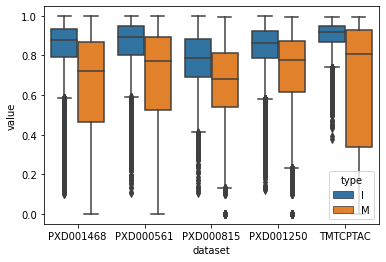

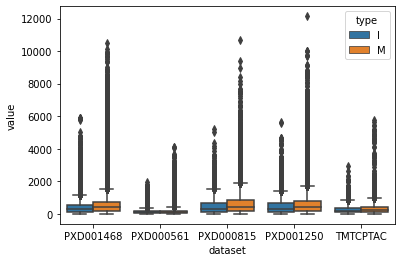

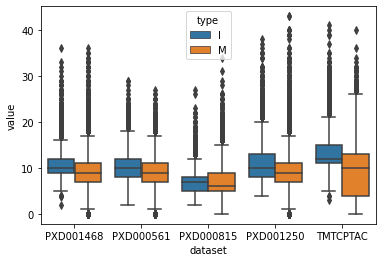

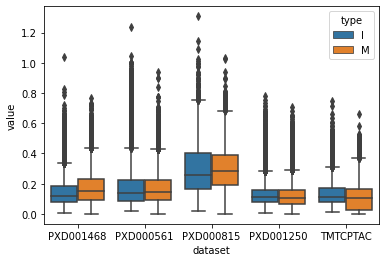

In [23]:
to_write = pd.concat(metrics)
for m in ["corr","rt-pred-error","by-count","by-explained"]:
    sns.boxplot(x="dataset",y="value",hue="type",data=to_write[to_write["metric"]==m])
    plt.show()

In [24]:
to_write[to_write["dataset"]=="TMTCPTAC"]["type"].value_counts()

M    129456
I    103244
Name: type, dtype: int64

In [25]:
to_write.to_csv("comparison_counts_stats.csv",index=False)